# Obrazki
Główną biblioteką do wykorzystania do klasyfikacji obrazów jest torchvision, torch rozpoczyna swoje operacje od momentu kiedy obrazy przetwarzane są w tensory, ale wcześniej odwołuje się też do innych bibliotek takich jak Pillow czy OpenCV

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [3]:
# torch.cuda.set_device(0)
# device = torch.device("cpu")

device_type = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device_type)

print(f"Using device: {device}")

Using device: mps


# Zbiory danych
Razem z torchvision dostępne są standardowo wykorzystywane zbiory danych. Na potrzeby dzisiejszych ćwiczeń skorzystamy ze zbioru CIFAR-10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


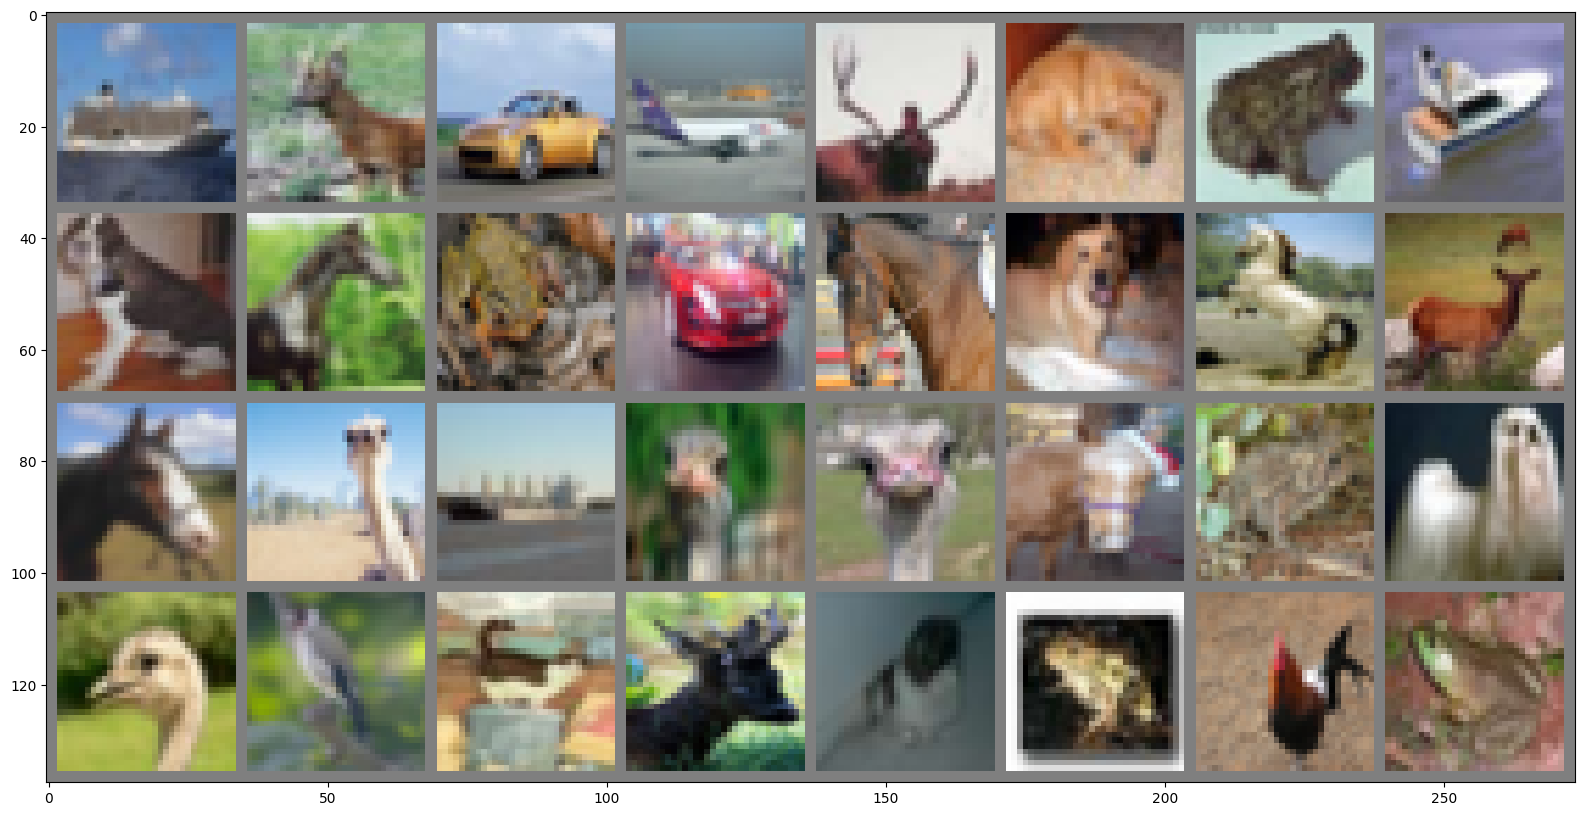

 ship  deer   car plane  deer   dog  frog  ship   dog horse  frog   car horse   dog horse  deer horse  bird  ship  bird  bird horse  frog   dog  bird  bird   cat  deer   dog  frog  bird  frog


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(trainloader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Weźmy wejście, zwróćmy uwagę na to jaka jest kolejność wymiarów:
[batch_size, channels, height, width]

In [6]:
images[0:1].size()

torch.Size([1, 3, 32, 32])

### Conv zmniejsza wymiarowość na height i width, dlaczego?

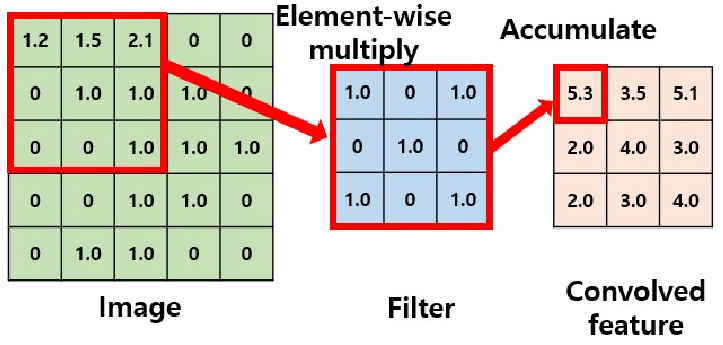

In [7]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 28, 28])

### Stride > 1

In [8]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 14, 14])

### Dodatkowy padding

In [9]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 30, 30])

### Filtry wcale nie muszą być kwadratowe

In [10]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=[5,2], stride=1, padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 28, 31])

### Na czym polega padding?

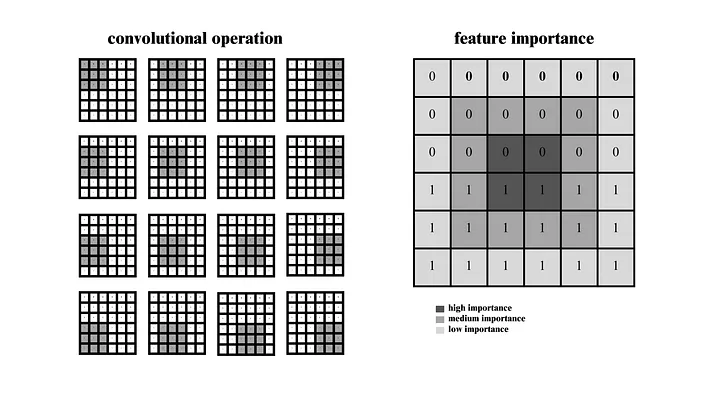

In [11]:
conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=[5,3], stride=[3,2], padding=[2,2], padding_mode='zeros').to(device)
out = conv1(images[0:1].to(device))
print(out.size())
out

torch.Size([1, 1, 11, 17])


tensor([[[[-0.0734, -0.2433, -0.2391, -0.2509, -0.2337, -0.1954, -0.2268,
           -0.2340, -0.1949, -0.1740, -0.2107, -0.2097, -0.2061, -0.1986,
           -0.2057, -0.2122, -0.1723],
          [-0.0347, -0.1018, -0.1142, -0.1032, -0.1156, -0.2005, -0.2207,
           -0.2678, -0.1956, -0.0669, -0.0281, -0.0691, -0.0501, -0.0666,
           -0.0674, -0.0908, -0.0663],
          [-0.0398, -0.1170, -0.1067, -0.0959, -0.1360, -0.1998, -0.2263,
           -0.1563, -0.1039, -0.1285, -0.1126, -0.0672, -0.0702, -0.0379,
           -0.0518, -0.0638, -0.0781],
          [-0.0409, -0.0917, -0.1228, -0.1231, -0.0552, -0.1089, -0.0908,
           -0.1190, -0.1293, -0.1384, -0.1576, -0.1000, -0.1192, -0.1282,
           -0.1120, -0.0835, -0.0952],
          [-0.0681, -0.1299, -0.0810, -0.0574,  0.1020,  0.0065, -0.0521,
           -0.0663, -0.0687, -0.0308, -0.0374, -0.0527, -0.0684, -0.0693,
           -0.1137, -0.0972, -0.0593],
          [-0.0464, -0.0779,  0.0719,  0.0481, -0.0474, -0.0068, 

In [12]:
list(conv1.parameters())

[Parameter containing:
 tensor([[[[-0.0420, -0.0687, -0.0748],
           [ 0.0111, -0.0316, -0.0152],
           [ 0.1157, -0.0587, -0.1327],
           [-0.0451, -0.0419,  0.1242],
           [ 0.0508,  0.0752, -0.1392]],
 
          [[-0.1177, -0.0341,  0.1304],
           [-0.1462,  0.0948, -0.1097],
           [-0.1407, -0.1140,  0.1168],
           [-0.0659,  0.0350,  0.0484],
           [ 0.1318,  0.0941,  0.0485]],
 
          [[-0.1161,  0.1353,  0.0440],
           [ 0.1142,  0.0224, -0.0179],
           [-0.0240,  0.0982, -0.0772],
           [ 0.0428, -0.1439, -0.1238],
           [-0.1201, -0.0919, -0.0059]]]], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0274], device='mps:0', requires_grad=True)]

## Pooling  czyli warstwa uśredniająca

In [13]:
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [14]:
pool1 = nn.MaxPool2d(kernel_size=2).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 16, 16])

### Domyślnie stride = kernel_size

In [15]:
pool1 = nn.MaxPool2d(kernel_size=2,stride=2).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 16, 16])

In [16]:
pool1 = nn.MaxPool2d(kernel_size=2,stride=1).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 31, 31])

### Max pooling

In [17]:
mini_example = images[0:1,0,0:4,0:4]
mini_example

tensor([[[-0.2471, -0.2627, -0.2627, -0.2627],
         [-0.2627, -0.2706, -0.2706, -0.2784],
         [-0.2863, -0.2863, -0.2863, -0.2863],
         [-0.2784, -0.2863, -0.2784, -0.2706]]])

In [18]:
pool1 = nn.MaxPool2d(kernel_size=2).to(device)
pool1(mini_example.to(device))

tensor([[[-0.2471, -0.2627],
         [-0.2784, -0.2706]]], device='mps:0')

### Avg pooling

In [19]:
pool1 = nn.AvgPool2d(kernel_size=2).to(device)
pool1(mini_example.to(device))

tensor([[[-0.2608, -0.2686],
         [-0.2843, -0.2804]]], device='mps:0')

# Trenowanie sieci konwolucyjnej

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [22]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnex

KeyboardInterrupt: 

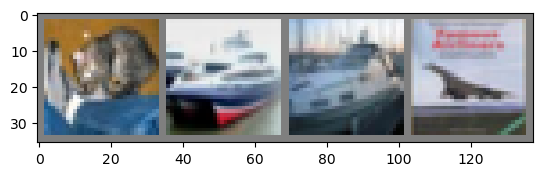

GroundTruth:    cat  ship  ship plane


In [24]:
images, labels = next(iter(testloader))
images = images[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
outputs = net(images.to(device))
outputs

tensor([[-2.8108, -3.7529, -0.5717,  2.6982, -1.8966,  1.2424,  2.0303, -2.7965,
         -1.6235, -3.4244],
        [ 2.8197,  3.4128, -2.5524, -3.1993, -5.1841, -4.7313, -5.5556, -5.8457,
          6.0983,  0.9606],
        [ 2.1410,  0.7000, -0.7016, -1.1892, -2.1552, -2.5500, -2.9221, -2.5312,
          2.3597, -0.7621],
        [ 4.1684, -2.6641,  0.4157, -2.2502, -2.2763, -5.1552, -4.0301, -4.4872,
          3.5228, -1.6088]], grad_fn=<AddmmBackward0>)

In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [28]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 65.2 %
Accuracy for class car   is: 72.2 %
Accuracy for class bird  is: 52.2 %
Accuracy for class cat   is: 31.5 %
Accuracy for class deer  is: 61.4 %
Accuracy for class dog   is: 55.4 %
Accuracy for class frog  is: 69.9 %
Accuracy for class horse is: 64.0 %
Accuracy for class ship  is: 79.2 %
Accuracy for class truck is: 68.7 %


### Mini zadanie: Spróbuj poprawić jakość klasyfikatora zmieniając parametry sieci

# Data augmentation

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


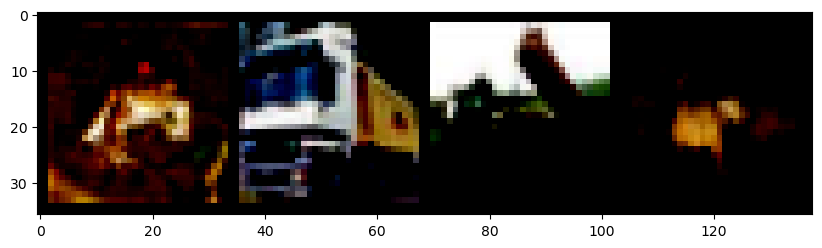

 frog truck truck  deer


In [30]:
plt.figure(figsize = (10,7))
images, labels = next(iter(trainloader))
images = images[:4]
labels = labels[:4]

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

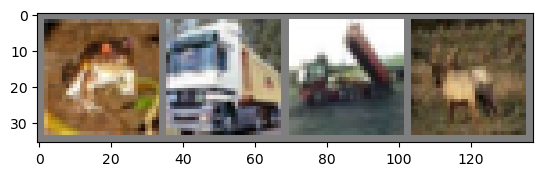

In [32]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


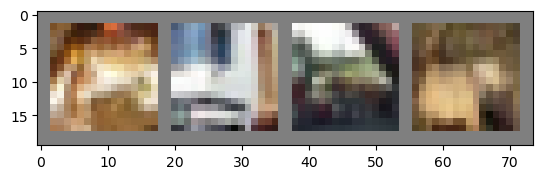

In [33]:
transform = transforms.Compose(
    [transforms.CenterCrop(16),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


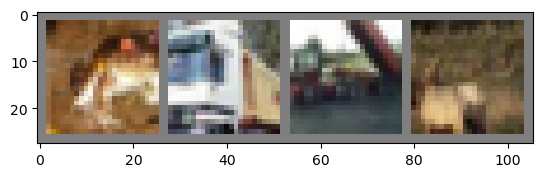

In [34]:
transform = transforms.Compose(
    [transforms.RandomCrop(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


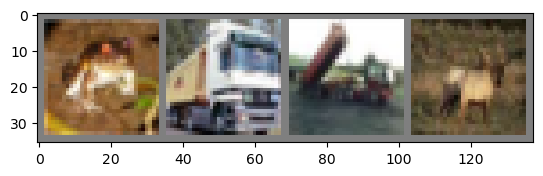

In [35]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


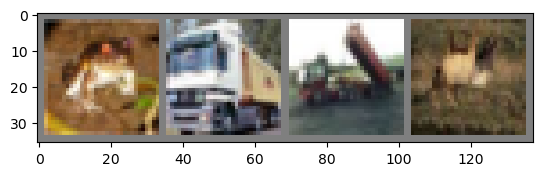

In [36]:
transform = transforms.Compose(
    [transforms.RandomVerticalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


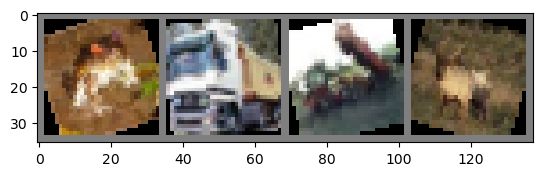

In [37]:
transform = transforms.Compose(
    [transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

Files already downloaded and verified


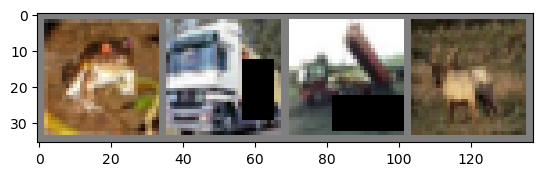

In [38]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

### Połączenie w całość

Files already downloaded and verified


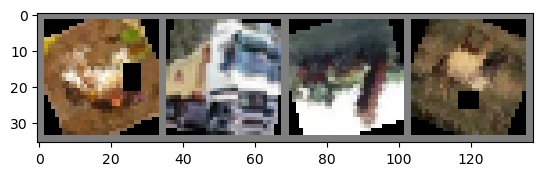

In [39]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

In [40]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,num_workers=16)

Files already downloaded and verified


In [20]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [22]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 1.289
[2/5] loss: 1.104
[3/5] loss: 1.024
[4/5] loss: 0.971
[5/5] loss: 0.932
Finished Training


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [24]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/10] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/10] loss: 0.904
[2/10] loss: 0.882
[3/10] loss: 0.866
[4/10] loss: 0.849
[5/10] loss: 0.835
[6/10] loss: 0.827
[7/10] loss: 0.813
[8/10] loss: 0.805
[9/10] loss: 0.801
[10/10] loss: 0.792
Finished Training


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


# Współcześnie stosowane modele

In [26]:
import torchvision.models as models
resnet18 = models.resnet18()

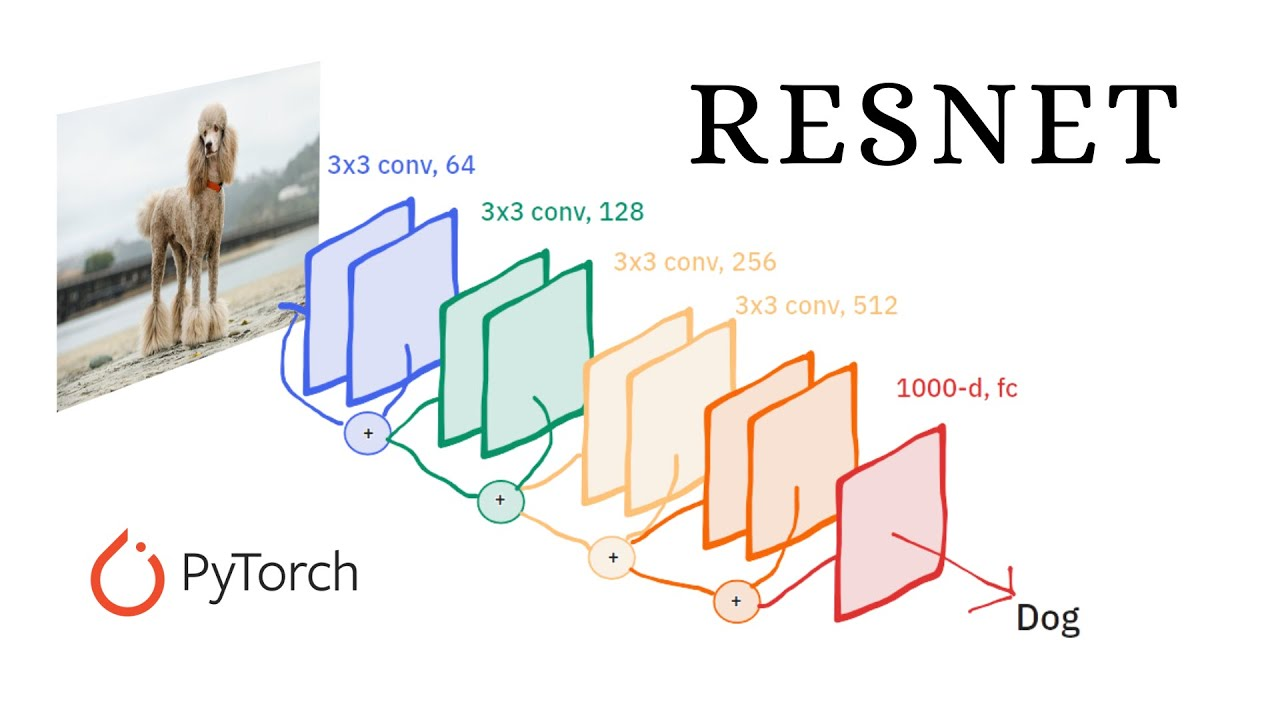

In [27]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Pytanie: po co nam Conv2d z kernel_size=(1,1)?

## Porównanie liczby parametrów

In [28]:
params_sum = 0
for params in net.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

62006

In [29]:
params_sum = 0
for params in resnet18.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

11689512

In [30]:
densenet = models.densenet161()

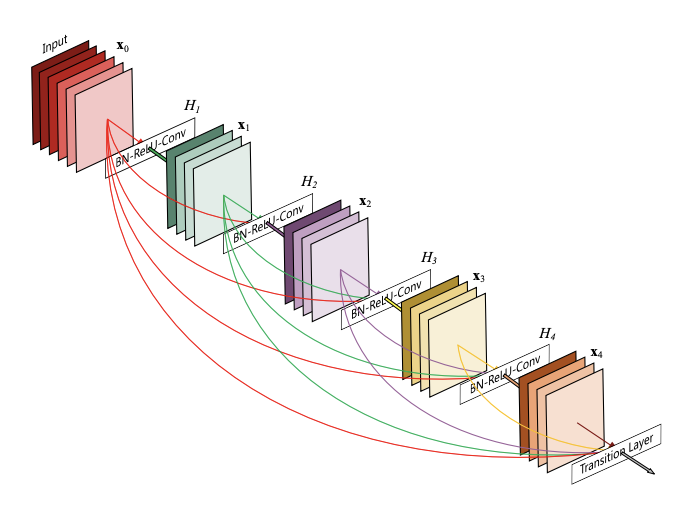

In [31]:
params_sum = 0
for params in densenet.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

28681000

In [74]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Zanikanie gradientu

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class LongNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.n_convs =  20
        n_channels = 10
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
        self.convs = [nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=2) for _ in range(self.n_convs)]
        self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]
     
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(n_channels * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        for i in range(self.n_convs):
            x = F.relu(self.convs[i](x))
            x = self.bns[i](x)
        x = self.pool1(x)
#         print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


long_net = LongNet().to(device)
for conv in long_net.convs:
    conv.to(device)
for bn in long_net.bns:
    bn.to(device)
long_net

LongNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1440, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(long_net.parameters(), lr=0.001)

[1/5] loss: 1.650


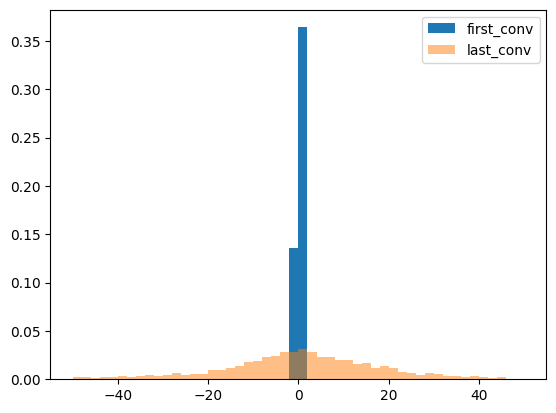

[2/5] loss: 1.666


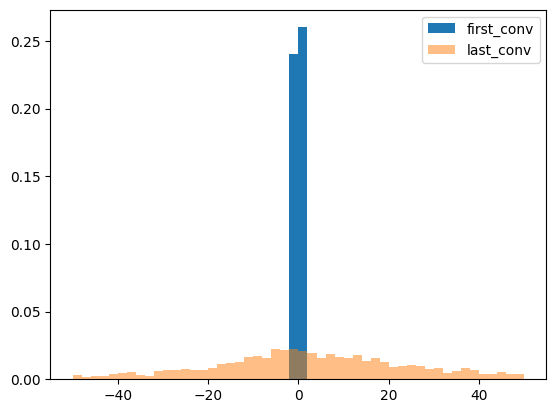

[3/5] loss: 1.667


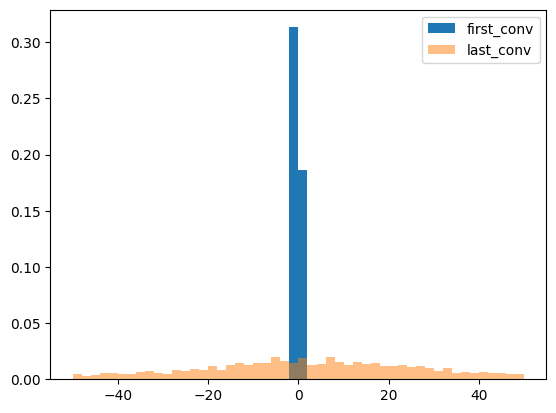

[4/5] loss: 1.630


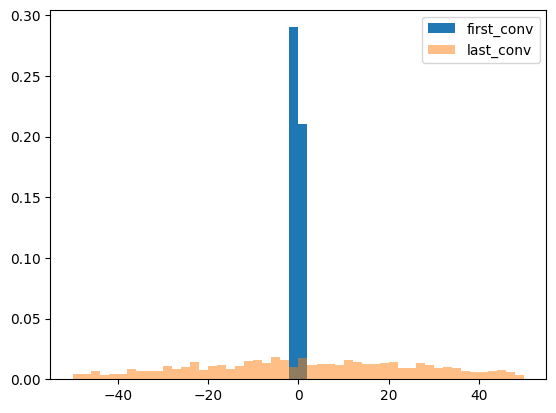

[5/5] loss: 1.632


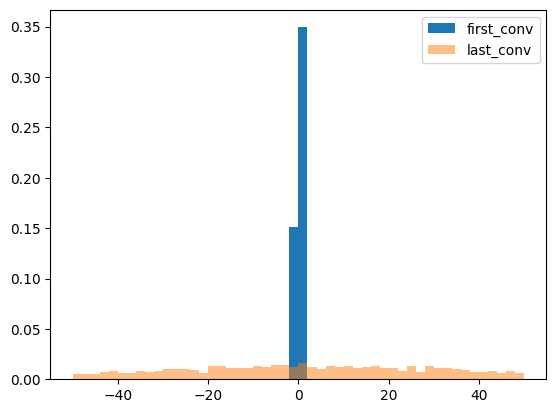

Finished Training


In [36]:
n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = long_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1 , n_epochs, running_loss / 2000))
    running_loss = 0.0
#     pd.DataFrame(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1)).hist(bins=30)
    plt.hist(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1),bins=50, label="first_conv",density=True,range=[-50,50])
    plt.hist(long_net.convs[9].weight.grad.cpu().detach().numpy().reshape(-1),bins=50, alpha=0.5, label="last_conv",density=True,range=[-50,50])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()
    

print('Finished Training')

In [37]:
import torch.nn as nn
import torch.nn.functional as F


class LongNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.n_convs =  20
        n_channels = 10
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
        self.convs = [nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2) for _ in range(self.n_convs)]
        self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]
     
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(n_channels * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x_2 = F.relu(self.conv2(x))
        x = x_2
        for i in range(self.n_convs):
            x = torch.cat([x,x_2],dim=1)
            x = F.relu(self.convs[i](x))
            x = self.bns[i](x)
        x = self.pool1(x)
#         print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


long_net = LongNet().to(device)
for conv in long_net.convs:
    conv.to(device)
for bn in long_net.bns:
    bn.to(device)
long_net

LongNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1440, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

[1/5] loss: 1.806


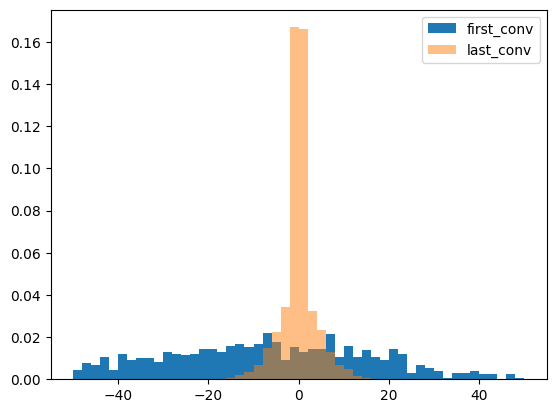

[2/5] loss: 1.806


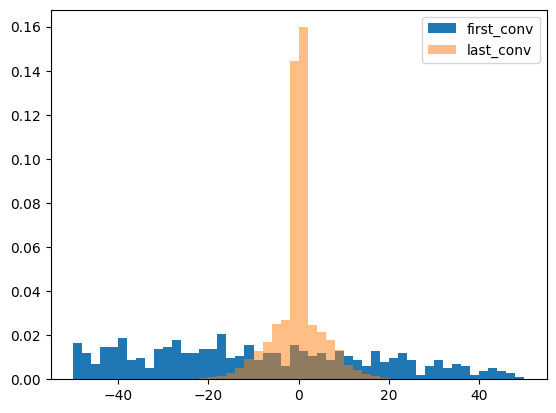

[3/5] loss: 1.806


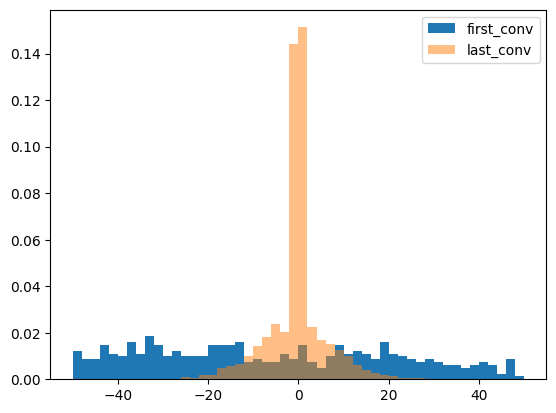

[4/5] loss: 1.806


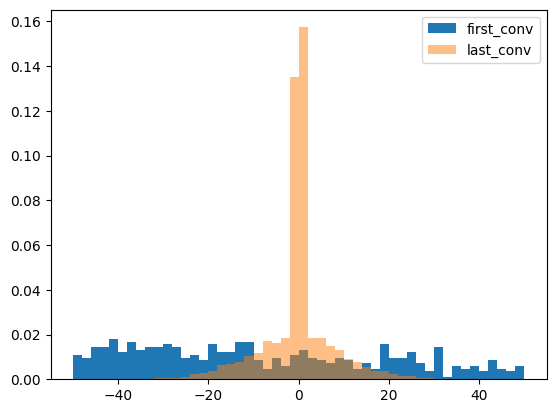

[5/5] loss: 1.806


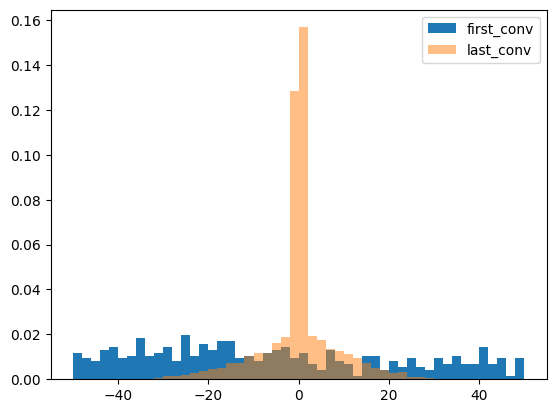

Finished Training


In [38]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = long_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1 , n_epochs, running_loss / 2000))
    running_loss = 0.0
#     pd.DataFrame(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1)).hist(bins=30)
    plt.hist(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1),bins=50, label="first_conv",density=True,range=[-50,50])
    plt.hist(long_net.convs[9].weight.grad.cpu().detach().numpy().reshape(-1),bins=50, alpha=0.5, label="last_conv",density=True,range=[-50,50])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()
    

print('Finished Training')

In [41]:
from torchviz import make_dot

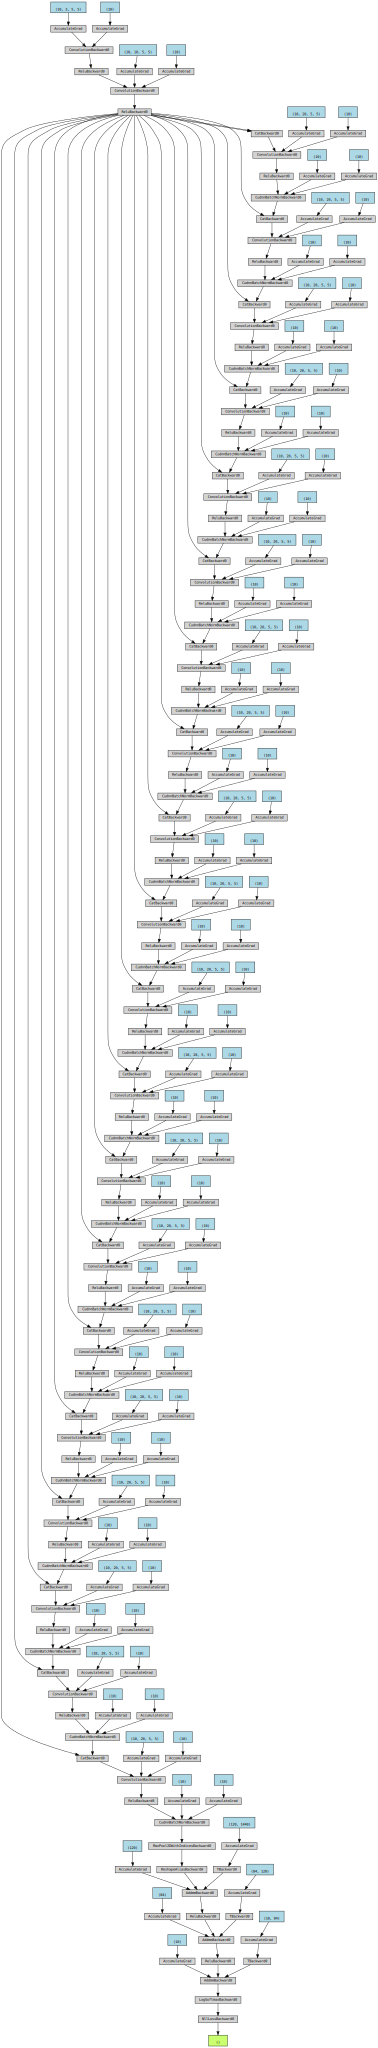

In [42]:
make_dot(loss)

# Co tak naprawdę robią CNN

In [43]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
#     plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [45]:
import seaborn as sns

In [46]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/1, nrows/20))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [47]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [48]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]

    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                plot_filters_multi_channel(weight_tensor[:,:3,:,:])
                print("Plot limited to first 3 channels only")

    else:
        print("Can only visualize layers which are convolutional")

In [51]:
alexnet = models.alexnet(weights="IMAGENET1K_V1")

In [52]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

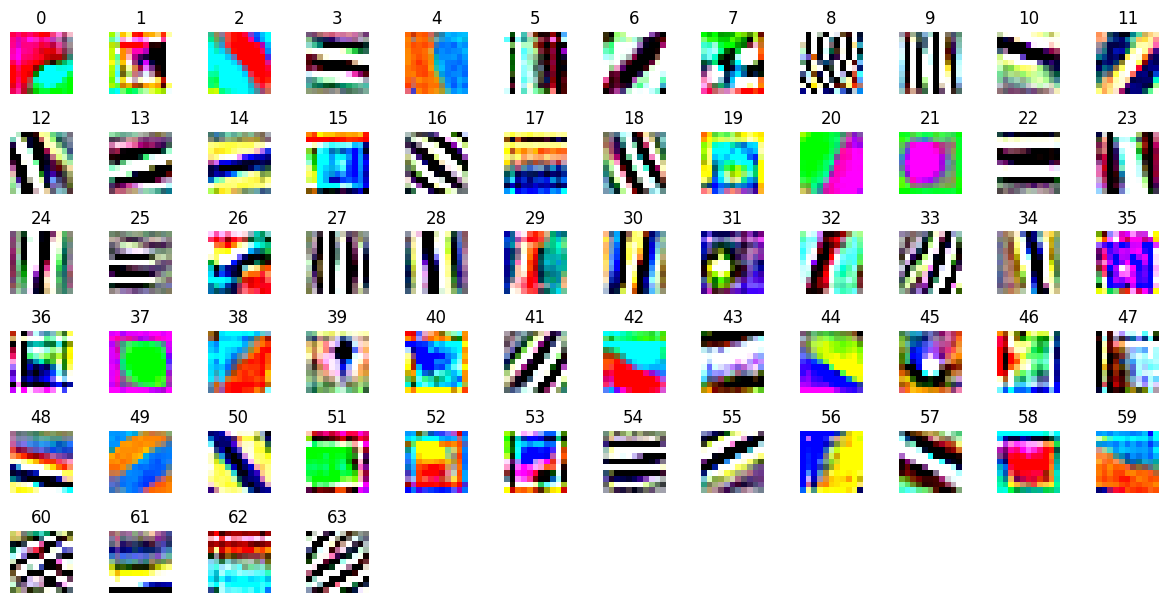

In [53]:
plot_weights(alexnet, 0, single_channel = False)

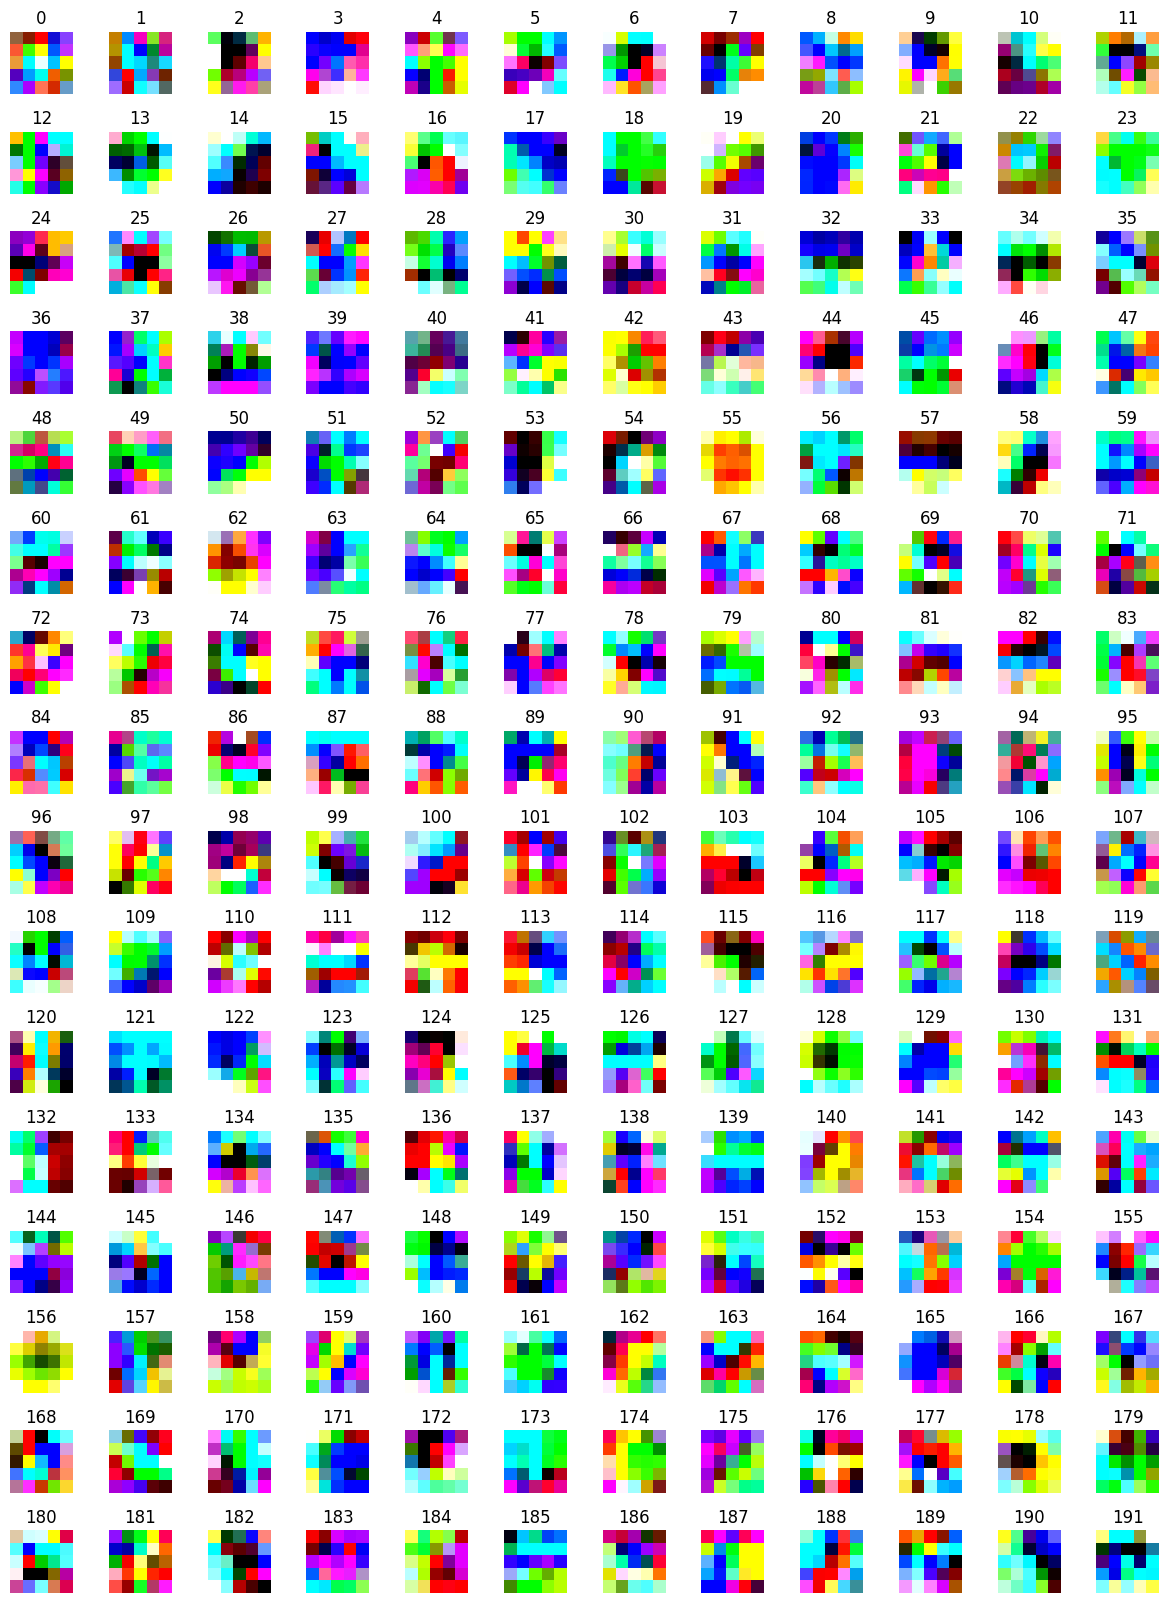

Plot limited to first 3 channels only


In [54]:
plot_weights(alexnet, 3, single_channel = False)

# Mini zadanie
Znajdź błędy i napraw model tak żeby działał i uczył się na zbiorze fashionMNIST. Podpowiedź:

https://twitter.com/ylecun/status/1459943933027487744

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [4]:
transform = transforms.Compose(
    [])

batch_size = 32

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class FashionNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(5)
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = FashionNet().to("cpu")
net

FashionNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')